In [1]:
from ising_model import ClassicIsing
import electron
from grid import Grid, HoleGrid, Mobius, Cylinder, Torus
import matplotlib.pyplot as plt
import numpy as np

Equilibrator

In [ ]:
def equilibrate_grid(grid, equil_tolerance=.9, mag_hist = False, J=1):
    """
    run the simulation until the grid equilibrates. That is, until the mean magnetization in the low temp regime
    stops changing significantly
    
    Parameters:
    -----------
    grid : Grid
        The grid to equilibrate
    tolerance : float
        The tolerance for equilibration. When the change in average magnetization over 5 steps is less than this value,
        the grid is considered equilibrated.
    mag_hist : bool
        If True, return the history of average magnetizations instead of just whether equilibrated.
    J : float
        The coupling constant for the Ising model.
    """

    max_steps = grid.n_x * grid.n_y * 5  # arbitrary large number of steps to prevent infinite loops

    temps = np.linspace(1, 1.2, 15)  # low temperature range for equilibration
    models = []

    # create a model for each temperature
    for T in temps:
        model = ClassicIsing(grid, temperature=T, ferromagnetivity=J, Mf_External=0)
        models.append(model)

    if mag_hist:
        total_hist = []

    # track average magnetizations by step
    is_equilibrated = False
    avg_mags_hist = []
    for step in range(max_steps):
        mags = []
        # step each model once and record magnetizations
        for model in models:
            model.runSimulation(1)
            mags.append(model.magnetization())
        avg_mags = np.mean(mags)
        if mag_hist:
            total_hist.append(avg_mags)
        avg_mags_hist.append(avg_mags)
        if step > 5:
            # check past 5 steps for equilibration by seeing if all magnitudes are greater than tolerance
            if np.all(np.mean(avg_mags_hist[-5:]) > equil_tolerance):
                is_equilibrated = True
                return total_hist if mag_hist else is_equilibrated
    return total_hist if mag_hist else is_equilibrated

def proper_equilibration(grid, equil_tolerance=.9, J=1):
    # equilibrate the grid first
    equilibrated = equilibrate_grid(grid, equil_tolerance=equil_tolerance, J=J)
    max_attempts = 10
    attempt = 0
    while not equilibrated:
        print("Reached maximum steps without equilibration. Resampling grid and trying again.")
        grid.resetGrid()
        equilibrated = equilibrate_grid(grid, tolerance=equil_tolerance, J=J)
        attempt += 1
        if attempt >= max_attempts:
            raise ValueError("Maximum equilibration attempts reached. Change equilibration tolerance.")
    return equilibrated

Simulator

In [3]:
def B_vs_T(grid, temps, mc_steps, runs_per_T, J=1, equil_tolerance=1e-2):

    # equilibrate the intial grid
    proper_equilibration(grid, equil_tolerance=equil_tolerance, J=J)

    # for each temperature, perform simulation and record magnetization
    magnetizations = []
    for T in temps:
        isingModel = ClassicIsing(grid, temperature=T, ferromagnetivity=J,Mf_External=0)

        # perform equilibration and measurement runs multiple times to average
        total_mag = 0
        for run in range(runs_per_T):
            isingModel.runSimulation(mc_steps)
            total_mag += isingModel.magnetization()

        # average magnetization for this temperature and record it
        avg_mag = total_mag / runs_per_T
        magnetizations.append(avg_mag)

        # reset the grid for the next temperature
        isingModel.resetSimulation()

        # requilibrate the grid after resetting
        proper_equilibration(isingModel.grid, equil_tolerance=equil_tolerance, J=J)

    return magnetizations


Fits

In [4]:
def get_critical_temp(temps, mags):
    """
    Estimate the critical temperature from the magnetization vs temperature data.
    The critical temperature is estimated as the temperature at which the magnetization
    drops below half of its maximum value.
    
    Parameters:
    -----------
    temps : array-like
        Array of temperatures.
    mags : array-like
        Array of magnetizations corresponding to the temperatures.
        
    Returns:
    --------
    T_c : float
        Estimated critical temperature.
    """
    max_mag = max(mags)
    half_max_mag = max_mag / 2

    for T, M in zip(temps, mags):
        if M < half_max_mag:
            return T
    return None

def fit_cubic (temps, mags):
    """
    Fit a cubic polynomial to the magnetization vs temperature data.
    
    Parameters:
    -----------
    temps : array-like
        Array of temperatures.
    mags : array-like
        Array of magnetizations corresponding to the temperatures.
        
    Returns:
    --------
    coeffs : array
        Coefficients of the fitted cubic polynomial.
    """
    coeffs = np.polyfit(temps, mags, 3)
    return coeffs

def inflection_point_cubic(cubic_coeffs):
    """
    Calculate the inflection point of the fitted cubic polynomial.
    
    Parameters:
    -----------
    cubic_coeffs : array
        Coefficients of the fitted cubic polynomial.
        
    Returns:
    --------
    T_inflec : float
        Temperature at the inflection point.
    """
    # The inflection point occurs where the second derivative is zero
    a, b, c, d = cubic_coeffs
    # Second derivative: f''(T) = 6a*T + 2b
    # Set f''(T) = 0 and solve for T
    T_inflec = -b / (3 * a)
    return T_inflec

def tanh_func(T, a, b, c, d):
        return a * np.tanh(b * (T - c)) + d

def tanh_fit(temps, mags):
    """
    Fit a hyperbolic tangent function to the magnetization vs temperature data.
    
    Parameters:
    -----------
    temps : array-like
        Array of temperatures.
    mags : array-like
        Array of magnetizations corresponding to the temperatures.
        
    Returns:
    --------
    popt : array
        Optimal values for the parameters of the tanh function.
    """
    from scipy.optimize import curve_fit

    popt, _ = curve_fit(tanh_func, temps, mags, p0=[1, 1, 1, 0])
    return popt

def inflection_point(tanh_params):
    """
    Calculate the inflection point of the fitted hyperbolic tangent function.
    
    Parameters:
    -----------
    tanh_params : array
        Parameters of the fitted tanh function.
        
    Returns:
    --------
    T_inflec : float
        Temperature at the inflection point.
    """
    a, b, c, d = tanh_params
    return c  # The inflection point occurs at T = c

Finding the expected magnitude of equilibrium magnetization at low temps.

In [ ]:
N = 30            # Lattice size
J = 1             # Coupling constant

# grid = Grid(n_x=N, n_y=N, gridPointObject=electron.ClassicElectron, record_history=False)
# mags = equilibrate_grid(grid, equil_tolerance=.9, mag_hist=True, J=J)

# holeGrid = HoleGrid(n_x=10, n_y=10, gridPointObject=electron.ClassicElectron, hole_grid=np.ones((3,3)) ,c_y=2, c_x=2, record_history=False)
# mags = equilibrate_grid(holeGrid, equil_tolerance=.8, mag_hist=True, J=J)

# mobius = Mobius(n_x=10, n_y=10, gridPointObject=electron.ClassicElectron, record_history=False)
# mags = equilibrate_grid(mobius, equil_tolerance=.9, mag_hist=True, J=J)

# cylinder = Cylinder(n_x=10, n_y=10, gridPointObject=electron.ClassicElectron, record_history=False)
# mags = equilibrate_grid(cylinder, equil_tolerance=.9, mag_hist=True, J=J)

torus = Torus(n_x=10, n_y=10, gridPointObject=electron.ClassicElectron, record_history=False)
mags = equilibrate_grid(torus, equil_tolerance=.9, mag_hist=True, J=J)

# plot the mean magnetization over time
plt.figure(figsize=(8, 5))
plt.plot(mags, marker='o')
plt.xlabel('Equilibration Steps')
plt.ylabel('Average Magnetization')
plt.title('Average Magnetization for low temperatures during Equilibration')
plt.grid()
plt.show()

Magnitization vs Temperature

In [5]:
# --- Parameters ---
N = 30                         # Lattice size
J = 1                          # Coupling constant
temps = np.linspace(1, 2.4, 40)  # Temperature range
mc_steps = 70                  # sweeps for measurement
runs_per_T = 15                 # Average over multiple runs
# ------------------

# Note tolerance values. For different grid types, different tolerances may be needed. Reference above cell.

# basic_grid = Grid(n_x=N, n_y=N, gridPointObject=electron.ClassicElectron, record_history=False)
# mags = B_vs_T(basic_grid, temps, mc_steps, runs_per_T, J=J, equil_tolerance=.9)

# holeGrid = HoleGrid(n_x=10, n_y=10, gridPointObject=electron.ClassicElectron, hole_grid=np.ones((3,3)) ,c_y=2, c_x=2, record_history=False)
# mags = B_vs_T(holeGrid, temps, mc_steps, runs_per_T, J=J, equil_tolerance=.8)

# mobius = Mobius(n_x=10, n_y=10, gridPointObject=electron.ClassicElectron, record_history=False)
# mags = B_vs_T(mobius, temps, mc_steps, runs_per_T, J=J, equil_tolerance=.9)

# cylinder = Cylinder(n_x=10, n_y=10, gridPointObject=electron.ClassicElectron, record_history=False)
# mags = B_vs_T(cylinder, temps, mc_steps, runs_per_T, J=J, equil_tolerance=.9)

torus = Torus(n_x=10, n_y=10, gridPointObject=electron.ClassicElectron, record_history=False)
mags = B_vs_T(torus, temps, mc_steps, runs_per_T, J=J, equil_tolerance=.9)

crit_T = get_critical_temp(temps, mags)
cubic_coeffs = fit_cubic(temps, mags)
cubic_critical_T = inflection_point_cubic(cubic_coeffs)
cubic_poly = np.poly1d(cubic_coeffs)
tanh_fit_params = tanh_fit(temps, mags)
tanh_critical_T = inflection_point(tanh_fit_params)

Plotting

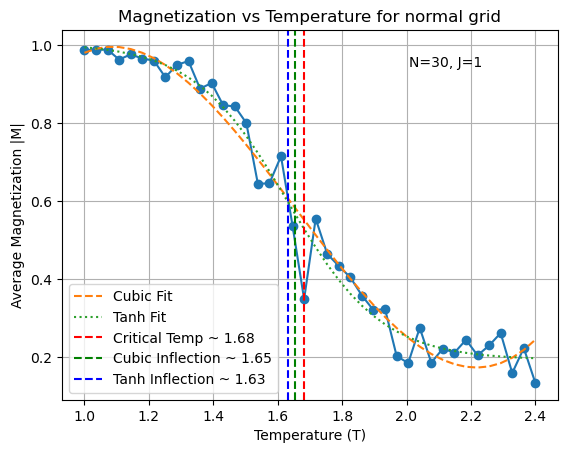

In [7]:
# graphing the results
plt.plot(temps, mags, marker='o')
plt.plot(temps, cubic_poly(temps), linestyle='--', label='Cubic Fit')
plt.plot(temps, tanh_func(temps, *tanh_fit_params), linestyle=':', label='Tanh Fit')
plt.xlabel('Temperature (T)')
plt.ylabel('Average Magnetization |M|')
plt.title('Magnetization vs Temperature for normal grid')
plt.text(0.7, 0.9, f'N={N}, J={J}', transform=plt.gca().transAxes)
# mark the critical temperature
plt.axvline(x=crit_T, color='r', linestyle='--', label=f'Critical Temp ~ {crit_T:.2f}')
plt.axvline(x=cubic_critical_T, color='g', linestyle='--', label=f'Cubic Inflection ~ {cubic_critical_T:.2f}')
plt.axvline(x=tanh_critical_T, color='b', linestyle='--', label=f'Tanh Inflection ~ {tanh_critical_T:.2f}')
plt.legend()
plt.grid()
plt.show()